### Ngozi Ihemelandu

# CS534 Homework 4

Put your homework in the directory with your name. Please mentionin this file the names of any students with whom you collaborated. If you didn't collaborate with anyone, mark your collaborators as "None." Remember, your goal is to communicate. Full credit will be given only to correct solutions which are described clearly. Convoluted and obtuse descriptions will receive low marks. To complete your homework, you may ONLY consult the following material:

lecture slides course notes you or others took during lecture. the required text (CLRS) websites that may clarify the concepts covered in the material but do not in any way provide complete solutions to the problems. Deadline 04/22/2019

Please provide an answer to the following question:

# Question 1 (15 pts)

Implement the ADABoost algorithm by using the scikit implementation of the logistic regression. Evaluate the result on a real dataset between a single logistic regression and AdaBoost (use K-Fold cross validation).

This links can be helpful: http://rob.schapire.net/papers/explaining-adaboost.pdf and https://en.wikipedia.org/wiki/AdaBoost


In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

class AdaBoostClassifier():
    print("base_estimator MUST be logistic Regression model")
    def __init__(self, base_estimator, n_estimators=10, random_state=None ):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.estimators_list = []          # holds the m estimators fitted on weighted samples
        self.sample_weight_list = []       # list of sample weight vectors used to weight the sample at each estimator fit
        self.estimators_error_list = []    # list of errors made by each weak estimators
        self.estimators_weight_list = []   # list of weights for each weak estimators
        self.y_pred_list = []
        
    def fit(self, X_train, y_train, sample_weight=None):
        """
        Build a boosted classifier
        """
        n_obs = len(y_train)          # sample size
        
        # Initialize the observation weights
        sample_weight =  sample_weight
        if sample_weight==None:
            sample_weight = np.ones(n_obs)/n_obs
        
        # Fit m estimators with weighted samples
        for m in range(self.n_estimators):
            
            self.sample_weight_list.append(sample_weight)  # append vector of sample weight to the list
            
            # Fit a classifier Gm(x) to the training data using weights (sample_weight_i)
            log_reg = self.base_estimator.fit(X_train, y_train, sample_weight=sample_weight)
            y_pred = log_reg.predict(X_train)

            # Estimator error
            err_m = np.sum(sample_weight*(y_pred != y_train))/np.sum(sample_weight)
            
            # Estimator weight/Coefficient
            alpha_m = np.log((1-err_m)/err_m)

            # Compute Boost sample weights
            sample_weight = sample_weight * np.exp(alpha_m * (y_pred != y_train))

            #Update list for each weak estimator
            self.estimators_list.append(log_reg)
            self.estimators_weight_list.append(alpha_m)
            self.y_pred_list.append(y_pred)
            self.estimators_error_list.append(err_m)
        
        return self
    
    def predict(self, X_t):
        n_obs = X_t.shape[0]
        pred_list = [clf.predict(X_t) for clf in self.estimators_list]
        y_predict = np.array([ np.sign((np.asarray(pred_list)[:,idx] * np.asarray(self.estimators_weight_list)).sum()) 
                              for idx in range(n_obs)])
        
        return(y_predict)  

base_estimator MUST be logistic Regression model


In [2]:
#load the iris data
filename = "iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
data_iris = pd.read_csv(filename, names=names)
data_iris.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
# classify iris dataset (Iris-Versicolor vs. others)
X = data_iris[['sepal-length', 'sepal-width', 'petal-length', 'petal-width']].values
y = data_iris["class"]=='Iris-versicolor'
y = y.values.astype(int)

#Split data into train and test(This test set held out for final evaluation)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Use the Stratified Cross Validation for model assessment - to obtain 10 accuracy measurements (distributions), 
# which allows us to estimate a central tendency(mean) and a spread(standard deviation). 
n_splits=10
skf = StratifiedKFold(n_splits=n_splits, random_state=123, shuffle=True)
cvFolds = list(skf.split(X_train, y_train))
ave = 0
folds_performance = []

for i, fold in enumerate(cvFolds):
    
    train_index = fold[0]
    test_index = fold[1]
    cvX_train, cvX_test = X_train[train_index], X_train[test_index]
    cvy_train, cvy_test = y_train[train_index], y_train[test_index]
    
    # Fit Ada Boost with a logistic regression base estimator
    Ada_clf = AdaBoostClassifier(base_estimator = LogisticRegression(solver='lbfgs'), n_estimators = 5)
    Ada_clf.fit(cvX_train, cvy_train)
   
    # Test on k_i fold
    pred = Ada_clf.predict(cvX_test)
    accuracy_rate = np.mean(pred == cvy_test)
    folds_performance.append(accuracy_rate)
    ave = ave + accuracy_rate
    # Print the accuracy measurements (distribution)
    print("fold-",i,": ", accuracy_rate)
    
# Print the mean and standard deviation for the model estimation performance
print("Mean - model performance estimation: ", ave/n_splits)
se = np.array(folds_performance)
print("Standard deviation - model performance estimation: ", np.std(se))

fold- 0 :  0.5833333333333334
fold- 1 :  0.25
fold- 2 :  0.6363636363636364
fold- 3 :  0.5
fold- 4 :  0.7
fold- 5 :  0.4
fold- 6 :  0.6
fold- 7 :  0.6
fold- 8 :  0.6
fold- 9 :  0.8
Mean - model performance estimation:  0.5669696969696969
Standard deviation - model performance estimation:  0.14601030191210077


In [243]:
# Logistic Regression Model Fitting
ave = 0
folds_performance = []

# Use the Stratified Cross Validation for model assessment
# Estimate the mean and standard deviation of the obtained distribution
for i, fold in enumerate(cvFolds):
    
    train_index = fold[0]
    test_index = fold[1]
    cvX_train, cvX_test = X_train[train_index], X_train[test_index]
    cvy_train, cvy_test = y_train[train_index], y_train[test_index]
    
    # fit the standard Logistic Regression Model
    clf_logit = LogisticRegression(solver='lbfgs')
    clf_logit.fit(cvX_train, cvy_train)
    
    # Test on k_i fold
    pred = clf_logit.predict(cvX_test)
    accuracy_rate = np.mean(pred == cvy_test)
    folds_performance.append(accuracy_rate)
    ave = ave + accuracy_rate
    # Print the accuracy measurements (distribution)
    print("fold-",i,": ", accuracy_rate)

# Print the mean and standard deviation for the model estimation performance
print("Mean - model performance estimation: ", ave/n_splits)
se = np.array(folds_performance)
print("Standard deviation - model performance estimation: ", np.std(se))

fold- 0 :  0.75
fold- 1 :  0.75
fold- 2 :  0.6363636363636364
fold- 3 :  0.9
fold- 4 :  0.6
fold- 5 :  0.8
fold- 6 :  0.9
fold- 7 :  0.7
fold- 8 :  0.4
fold- 9 :  0.9
Mean - model performance estimation:  0.7336363636363638
Standard deviation - model performance estimation:  0.1509090909090909


##### From the above statistics, it appears that adding multiple linear models together will still be a linear model hence the power of the boosting algorithm is not improved.

## Question 2 (10 pts)
Use DBscan (try with different parameters) and K-means (K=3) on IRIS Dataset and discuss/compare the results with the iris ground truth.
Please provide an explanation of why K-fold cross validation is not required for the comparison among these different algorithms.

In [6]:
# Import all dependencies
from sklearn.cluster import DBSCAN, KMeans
import matplotlib.pyplot as plt
import scipy.spatial

In [7]:
data_iris["class"].value_counts()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: class, dtype: int64

In [8]:
# We will use the Iris dataset already imported in question 1
X_data_DBSCAN = data_iris.iloc[: , 0:4]
X_data_Kmeans = data_iris.iloc[: , 0:4]
y_data = np.where(data_iris["class"]=='Iris-versicolor', 0, np.where(data_iris["class"]=='Iris-virginica', 1, 2))
pd.Series(y_data).value_counts()

2    50
1    50
0    50
dtype: int64

#### K-MEANS

2    62
1    50
0    38
dtype: int64


Text(0.5, 1.0, 'Predicted Clusters by K-Means')

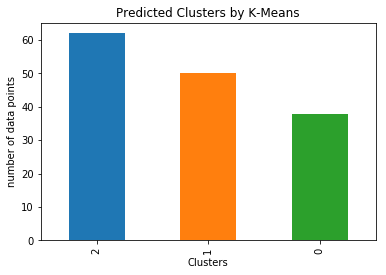

In [12]:
# Using K-means, cluster the data into three clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)
kmeans.predict(X)
pred_labels = pd.Series(kmeans.labels_)
print(pred_labels.value_counts())
(pred_labels.value_counts()).plot.bar()
plt.xlabel('Clusters')
plt.ylabel('number of data points')
plt.title('Predicted Clusters by K-Means')

#####  Compare the result of K-means with ground truth

Ground Truth Cluster -  0
2    0.96
0    0.04
Name: pred_y, dtype: float64
Ground Truth Cluster -  1
0    0.72
2    0.28
Name: pred_y, dtype: float64
Ground Truth Cluster -  2
1    1.0
Name: pred_y, dtype: float64


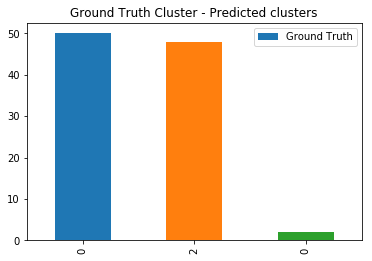

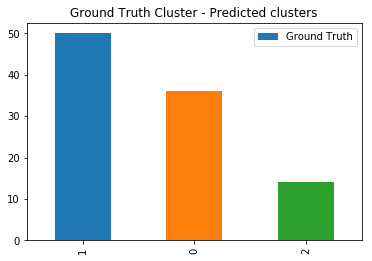

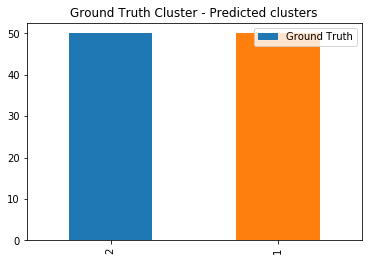

In [20]:
X_data_Kmeans["true_y"] = y_data
X_data_Kmeans["pred_y"] = kmeans.labels_
grouped = X_data_Kmeans.groupby('true_y')

for name,group in grouped:
    print("Ground Truth Cluster - ", name)
    print(group["pred_y"].value_counts()/50)
    
    fig, ax = plt.subplots()
    merged_clusts = pd.concat([X_data_Kmeans[X_data_Kmeans["true_y"]==name]["true_y"].value_counts(), group["pred_y"].value_counts()])
    merged_clusts.plot(kind='bar', legend = True)
    plt.title('Ground Truth Cluster - Predicted clusters')
    ax.legend(["Ground Truth"])

From the bar plots above, we see that the K-means algorithm does a good job of classifying data points in groups that align with the ground truth:
* 96% of data points from original group 0 clustered together and labeled 2
* 72% of data points from original group 1 clustered together and labeled 0
* 100% of data points from original group 2 clustered together and labeled 1

#### DBSCAN
##### Note - Predicted Cluster with label -1 indicates noise

##### DBSCAN core point that requires a minimum of 5 data points in a neighborhood of radius 0.15 

Text(0.5, 1.0, 'Predicted Clusters by DSCAN')

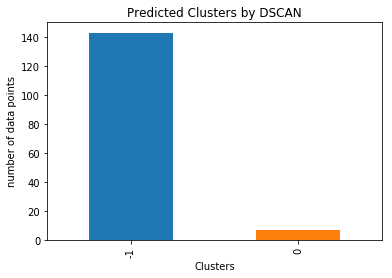

In [21]:
dbsc = DBSCAN(eps = .15, min_samples = 5).fit(X)

# Extract cluster labels
labels = dbsc.labels_

# Plot predicted custers
(pd.Series(labels).value_counts()).plot.bar()
plt.xlabel('Clusters')
plt.ylabel('number of data points')
plt.title('Predicted Clusters by DSCAN - (0.15,5)')

##### Compare the result with the ground truth

Ground Truth Cluster -  0
-1    50
Name: pred_y, dtype: int64
Ground Truth Cluster -  1
-1    50
Name: pred_y, dtype: int64
Ground Truth Cluster -  2
-1    43
 0     7
Name: pred_y, dtype: int64


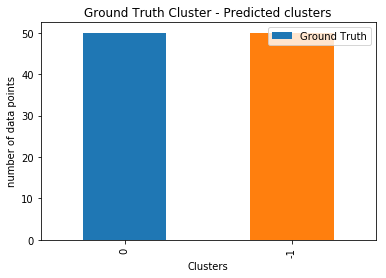

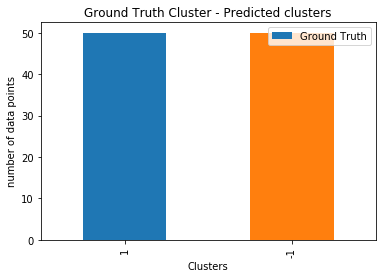

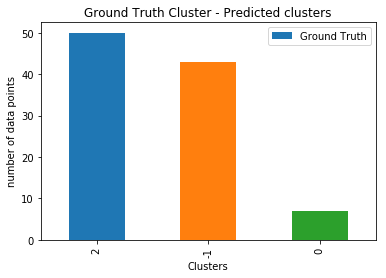

In [25]:
X_data_DBSCAN["true_y"] = y_data
X_data_DBSCAN["pred_y"] = labels

grouped = X_data_DBSCAN.groupby('true_y')
for name,group in grouped:
    fig, ax = plt.subplots()

    print("Ground Truth Cluster - ", name)
    groundTruth = X_data_DBSCAN[X_data_DBSCAN["true_y"]==name]["true_y"].value_counts()
    pred_clusters = group["pred_y"].value_counts()
    print(pred_clusters)
    merged_clusts = pd.concat([groundTruth, pred_clusters])
    merged_clusts.plot(kind='bar', legend = True)
    plt.title('Ground Truth Cluster - Predicted clusters')
    ax.legend(["Ground Truth"])
    plt.xlabel('Clusters')
    plt.ylabel('number of data points')

##### When the radius of the neighbourhood is quite small, as in our case, 0.15 DSCAN classifies most of the data points as outliers/noise

#### DBSCAN core point that requires a minimum of 5 data points in a neighborhood of radius 0.5 

Text(0.5, 1.0, 'Predicted Clusters by DSCAN - (0.5,5)')

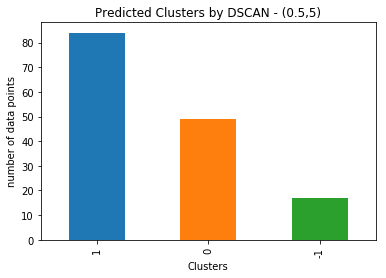

In [26]:
dbsc = DBSCAN(eps = .5, min_samples = 5).fit(X)
# Plot predicted custers
(pd.Series(dbsc.labels_).value_counts()).plot.bar()
plt.xlabel('Clusters')
plt.ylabel('number of data points')
plt.title('Predicted Clusters by DSCAN - (0.5,5)')

###### Compare the result with the ground truth

Cluster -  0
 1    0.88
-1    0.12
Name: pred_y, dtype: float64
Cluster -  1
 1    0.8
-1    0.2
Name: pred_y, dtype: float64
Cluster -  2
 0    0.98
-1    0.02
Name: pred_y, dtype: float64


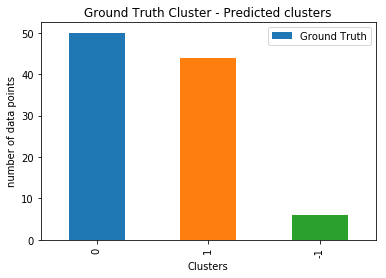

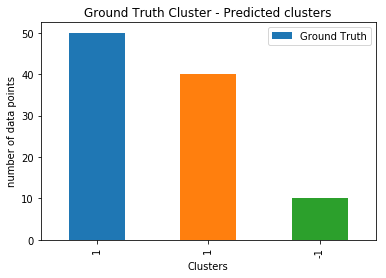

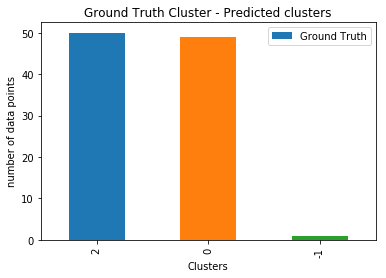

In [32]:
X_data_DBSCAN["true_y"] = y_data
X_data_DBSCAN["pred_y"] = dbsc.labels_
grouped = X_data_DBSCAN.groupby('true_y')
for name,group in grouped:
    fig, ax = plt.subplots()
    print("Cluster - ", name)
    print(group["pred_y"].value_counts()/50)
    
    merged_clusts = pd.concat([X_data_DBSCAN[X_data_DBSCAN["true_y"]==name]["true_y"].value_counts(), 
                               group["pred_y"].value_counts()])
    merged_clusts.plot(kind='bar', legend = True)
    plt.title('Ground Truth Cluster - Predicted clusters')
    plt.legend(["Ground Truth"])
    plt.xlabel('Clusters')
    plt.ylabel('number of data points')

#### The performance of the DSCAN algorithmn significantly improves with an increased radius of 0.5 and minumum points in a neighbourhood still set at 5
* 88% of data points from original group 0 and 80% of data points from original group 1 are clustered together and labeled 1
* 98% of data points from original group 2 are clustered together and labeled 0

##### DBSCAN core point that requires a minimum of 10 data points in a neighborhood of radius 0.5

Cluster -  0
 1    0.88
-1    0.12
Name: pred_y, dtype: float64
Cluster -  1
 1    0.56
-1    0.44
Name: pred_y, dtype: float64
Cluster -  2
 0    0.96
-1    0.04
Name: pred_y, dtype: float64


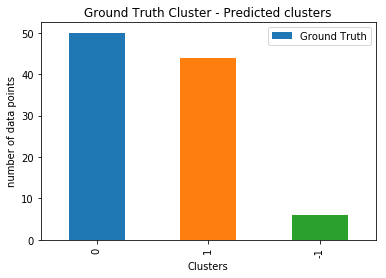

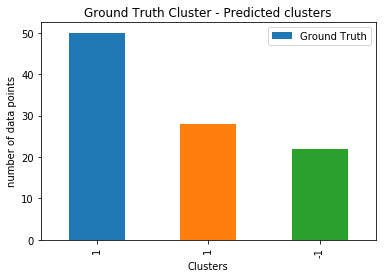

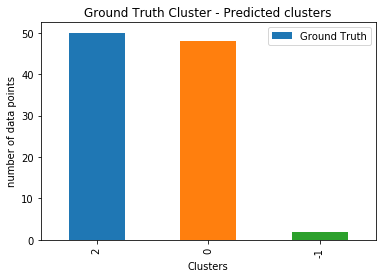

In [37]:
dbsc = DBSCAN(eps = .5, min_samples = 10).fit(X)

# Extract cluster labels
labels = dbsc.labels_

# Compare the result of DBSCAN with the ground truth
X_data_DBSCAN["true_y"] = y_data
X_data_DBSCAN["pred_y"] = labels
grouped = X_data_DBSCAN.groupby('true_y')
for name,group in grouped:
    fig, ax = plt.subplots()
    print("Cluster - ", name)
    print(group["pred_y"].value_counts()/50)
    merged_clusts = pd.concat([X_data_DBSCAN[X_data_DBSCAN["true_y"]==name]["true_y"].value_counts(), 
                               group["pred_y"].value_counts()])
    merged_clusts.plot(kind='bar', legend = True)
    plt.title('Ground Truth Cluster - Predicted clusters')
    plt.legend(["Ground Truth"])
    plt.xlabel('Clusters')
    plt.ylabel('number of data points')

#### The performance of the DSCAN algorithmn significantly improves with radius at 0.5 and minumum points in a neighbourhood still set at 10
* 88% of data points from original group 0 and 56% of data points from original group 1 are clustered together and labeled 1
* 96% of data points from original group 2 are clustered together and labeled 0

#### Explanation of why K-fold cross validation is not required for the comparison of Clustering algorithms.

K-fold cross validation is a technique used for model validation/assessment to evaluate a model's preformance as well as model selection. In order to perform these tasks, there must exists some ground truths. In other words, K-folds are used for classification/supervised problems where a label variable exists. On the other hand, clustering algorithms are used to solve unsupervised problems where the ground truth does not exist. That is the dataset doesn't have a label variable. 

# Extra Points ( 5pts)
Implement DBScan by using the KD-tree (you can use for the  KD-tree the implementation in scikit or Numpy). Note that the KD-tree is used for  K-nearest neighbor. 

In [39]:
spec = data_iris["class"].unique().tolist()
n,q = data_iris.shape
c = list(data_iris.columns.values)
p = q-1

spec = data_iris["class"].unique().tolist()
n,q = data_iris.shape
c = list(data_iris.columns.values)
p = q-1
X = data_iris[c[0:p]].values
y = data_iris[c[p]].values

In [40]:
def dbscan(X,min_size_cluster,dist_neighbor):
    n,_ = X.shape
    kdtree = scipy.spatial.KDTree(X)
    X_visit = np.zeros((n,1),dtype=bool)
    clusters = np.zeros((n,1))
    c = 0
    for k in range(0,n):
        if X_visit[k]==0: # if k has not been visited
            X_visit[k] = 1 # k is flagged
            # Find all points within distance "dist_neighbor" of point(s) 'X[k,:]'.
            Neighbors = kdtree.query_ball_point(X[k,:],dist_neighbor) 
            if len(Neighbors) < min_size_cluster:
                clusters[k] = -1 # Not a core point, mark as outlier
            else: # if the point has a enough neighbours, this makes it a core point
                c = c + 1 # Update cluster
                clusters[k] = c # we create a cluster and k belong to it
                while len(Neighbors) > 0: # Then we study all of its neighbors
                    i = Neighbors.pop()
                    if X_visit[i]==0:   # if i has not been visited, we flag it
                        X_visit[i] = 1
                        # Get the neighbours of X[i,:] within a radius of dist_neighbor
                        Vi = kdtree.query_ball_point(X[i,:],dist_neighbor)
                        if len(Vi)>=min_size_cluster: #This is a core point
                            Neighbors.extend(Vi) # add its neighbours
                        if clusters[i]<=0: # If marked as outlier(-1), change to C cause it is density reachable 
                                            # and a member of cluster c
                            clusters[i] = c
        return clusters

In [51]:
min_size_cluster = 5
dist_neighbor = 0.5
db_clusters = dbscan(X,min_size_cluster,dist_neighbor)
db_clusters = db_clusters.reshape(db_clusters.shape[0],)


Text(0.5, 1.0, 'Predicted Clusters by DSCAN - (0.5,5)')

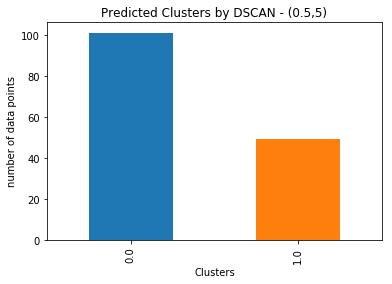

In [52]:
(pd.Series(db_clusters).value_counts()).plot.bar()
plt.xlabel('Clusters')
plt.ylabel('number of data points')
plt.title('Predicted Clusters by DSCAN - (0.5,5)')